Load And Split Data

In [1]:
import pandas as pd

data = pd.read_csv('train.csv', delimiter = ";")  # Load Train datasets
data_test = pd.read_csv('test.csv', delimiter = ";") # Load Test datasets

X_train = data['title'].values + data['text'].values
Y_train = data['label'].values

X_test = data_test['title'].values + data_test['text'].values
Y_test = data_test['label'].values

Tokenization And Preprocessing Data

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>') # Create Instance tokenizer with 5000 words popular
tokenizer.fit_on_texts(X_train) # Build Dictionary based on Train Datasets

# Mapping text -> tokenizer. Sequence -> list[number]
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding or Remove for every sequence has max length = 250
X_train_padded = pad_sequences(X_train_sequences, maxlen=250, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=250, padding='post')


Build Models LSTM with Keras

In [3]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.models import Sequential


model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=250), # Embedded input dimension = Dictionary, input length = Sequence max length
    SpatialDropout1D(0.2), # Prunning vector decrease Overfitting
    LSTM(100, dropout=0.2, recurrent_dropout=0.2), # Model LSTM
    Dense(1, activation='sigmoid') # Active Function sigmoid appropriate classified
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # optimize model, loss function and accuracy


Train Model

In [4]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Stop Training When Model Cant Learn
history = model.fit(X_train_padded, Y_train, validation_data=(X_test_padded, Y_test), # Training with: input - X_train_padded
                    epochs=10, batch_size=64, callbacks=[early_stopping], verbose=1)  #                output - Y_train
                                                                                      #                test - validation_data
                                                                                      #                timesteps - epochs
                                                                                      #                sample size - batch_size
                                                                                      #                optimize - callbacks

Epoch 1/10
381/381 [==============================] - 357s 928ms/step - loss: 0.2952 - accuracy: 0.8777 - val_loss: 0.2908 - val_accuracy: 0.8646
Epoch 2/10
381/381 [==============================] - 360s 945ms/step - loss: 0.2249 - accuracy: 0.9114 - val_loss: 0.1800 - val_accuracy: 0.9405
Epoch 3/10
381/381 [==============================] - 359s 941ms/step - loss: 0.2447 - accuracy: 0.8873 - val_loss: 0.2511 - val_accuracy: 0.8632
Epoch 4/10
381/381 [==============================] - 388s 1s/step - loss: 0.1854 - accuracy: 0.9251 - val_loss: 0.3692 - val_accuracy: 0.8451
Epoch 5/10
381/381 [==============================] - 367s 963ms/step - loss: 0.2141 - accuracy: 0.9120 - val_loss: 0.3080 - val_accuracy: 0.8547


Model Evaluation

In [5]:
#       With Accuracy

y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.4f}")
print("Báo cáo phân loại:")
print(classification_report(Y_test, y_pred))

254/254 [==============================] - 16s 62ms/step
Độ chính xác của mô hình: 0.9405
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3753
           1       0.92      0.98      0.95      4364

    accuracy                           0.94      8117
   macro avg       0.94      0.94      0.94      8117
weighted avg       0.94      0.94      0.94      8117



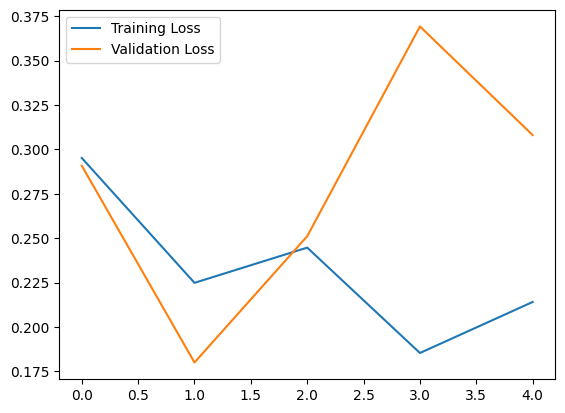

In [6]:
#       With Plot

import matplotlib.pyplot as plt

loss = history.history['loss'] # History of Loss Function
val_loss = history.history['val_loss'] # value of Loss Function

# Show plot

plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.show()

Save Models, History Train And Tokenizer

In [7]:
import pickle

model.save('fake_news_lstm.h5') # Save model

with open('tokenizer_lstm.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) # Save tokenizer

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f) # Save history

e:\asus\Machine Learning\RNN\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
